In [23]:
import os
import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [24]:
merged_data = pd.read_csv('merged_knn_imputed_filtered_data_panas.csv')
merged_data = merged_data.drop(columns='Unnamed: 0')

In [25]:
# make sure no na at this point
merged_data.isna().any().any()

np.False_

In [26]:
# split into our feature and target variables
pos_panas = merged_data['negative_affect_EMA']
neg_panas = merged_data['positive_affect_EMA']
merged_data = merged_data.drop(columns=['positive_affect_EMA', 'negative_affect_EMA'])
merged_data_no_bfi = merged_data.drop(columns=['BFI10_extroversion_PRE', 'BFI10_agreeableness_PRE', 'BFI10_conscientiousness_PRE', 'BFI10_neuroticism_PRE', 'BFI10_openness_PRE'])

In [27]:
best_params = {
    'pos_panas_with_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40},
    'pos_panas_no_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40},
    'neg_panas_with_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 35},
    'neg_panas_no_bfi': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 35}
}

In [28]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
datasets = {}
for target in [(pos_panas, 'pos_panas'), (neg_panas, 'neg_panas')]:
    for dataset in [(merged_data, 'with_bfi'), (merged_data_no_bfi, 'no_bfi')]:
        print(target[1]+'_'+dataset[1])
        gamma_model = sm.GLM(target[0], dataset[0])
        gamma_results = gamma_model.fit()
        p_values = gamma_results.pvalues
        significant_columns = p_values[p_values < 0.5].index
        sig_dataset = dataset[0][significant_columns]
        datasets[target[1]+'_'+dataset[1]] = (sig_dataset, target[0])
    
    df1 = 0
    ddf2 = 0
    targ = 'pos_panas'
    if len(list(datasets.keys()))==2:
        df1 = datasets['pos_panas_with_bfi'][0]
        df2 = datasets['pos_panas_no_bfi'][0]
    elif len(list(datasets.keys()))==4:
        df1 = datasets['neg_panas_with_bfi'][0]
        df2 = datasets['neg_panas_no_bfi'][0]
        targ = 'neg_panas'
    else:
        print('error')
        
    columns_in_df1_not_in_df2 = set(df1.columns) - set(df2.columns)
    columns_in_df2_not_in_df1 = set(df2.columns) - set(df1.columns)
    print("Columns only in with bfi for "+targ)
    for col in columns_in_df1_not_in_df2:
        print(f"  - {col}")
    print('---------')
    print("Columns only in w/out bfi for "+targ)
    for col in columns_in_df2_not_in_df1:
        print(f"  - {col}")

pos_panas_with_bfi
pos_panas_no_bfi
Columns only in with bfi for pos_panas
  - f_slp:fitbit_sleep_intraday_rapids_mindurationawakeunifiedmain_norm:7dhist
  - BFI10_extroversion_PRE
  - f_call:phone_calls_rapids_incoming_stdduration_norm:7dhist
  - f_slp:fitbit_sleep_summary_rapids_avgdurationinbedmain_norm:7dhist
  - f_blue:phone_bluetooth_doryab_countscansleastfrequentdeviceacrosssegmentsown_norm:7dhist
  - f_call:phone_calls_rapids_outgoing_timefirstcall_norm:7dhist
  - f_loc:phone_locations_barnett_circdnrtn_norm:7dhist
  - BFI10_agreeableness_PRE
  - f_call:phone_calls_rapids_incoming_countmostfrequentcontact_norm:7dhist
  - f_loc:phone_locations_doryab_timeattop1location_norm:7dhist
  - f_screen:phone_screen_rapids_mindurationunlock_norm:7dhist
  - BFI10_openness_PRE
  - f_loc:phone_locations_doryab_numberlocationtransitions_norm:7dhist
  - f_loc:phone_locations_locmap_percent_in_locmap_study_norm:7dhist
  - f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain_norm:7dhist
  - f

pos_panas_with_bfi
Cross_val scores: [-8.42416626 -7.59517524 -8.26839507 -7.64617615 -7.57738015]


100%|===================| 10577/10618 [03:45<00:00]        

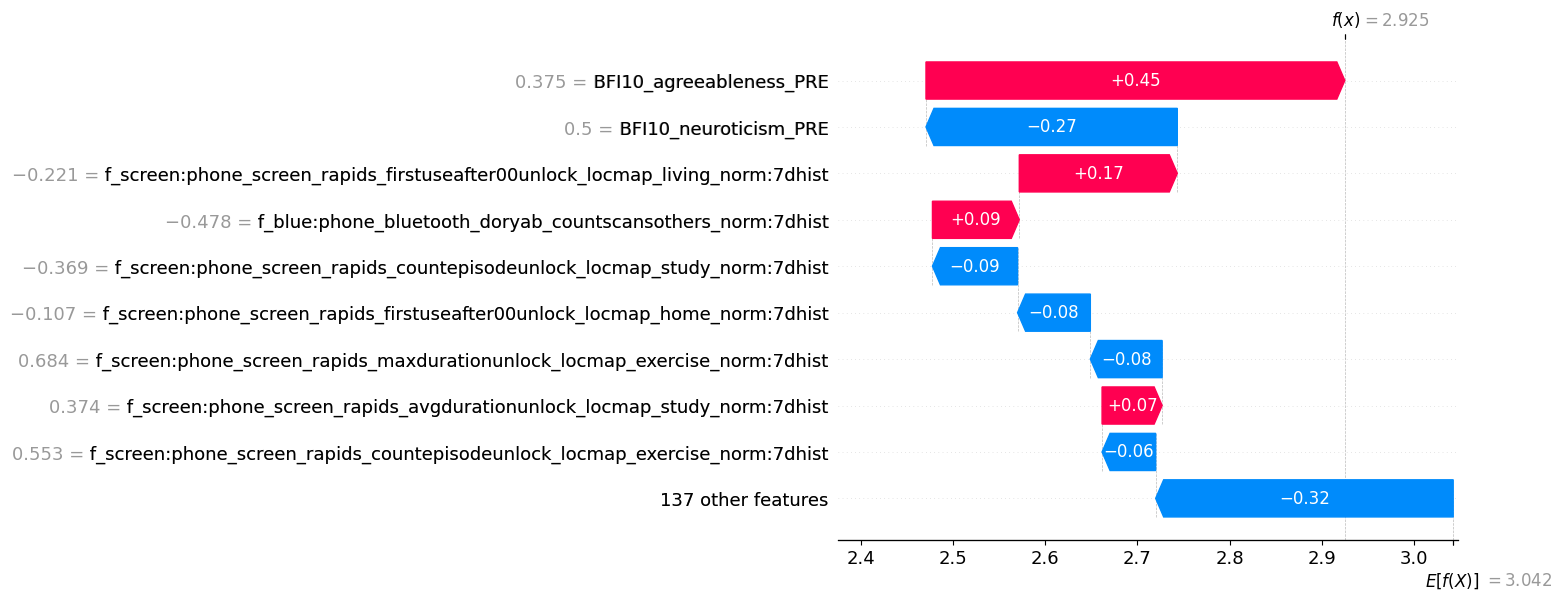

pos_panas_no_bfi
Cross_val scores: [-10.58642129  -9.51912968  -9.94890939  -9.67255855 -10.11757539]


100%|===================| 10588/10618 [03:40<00:00]        

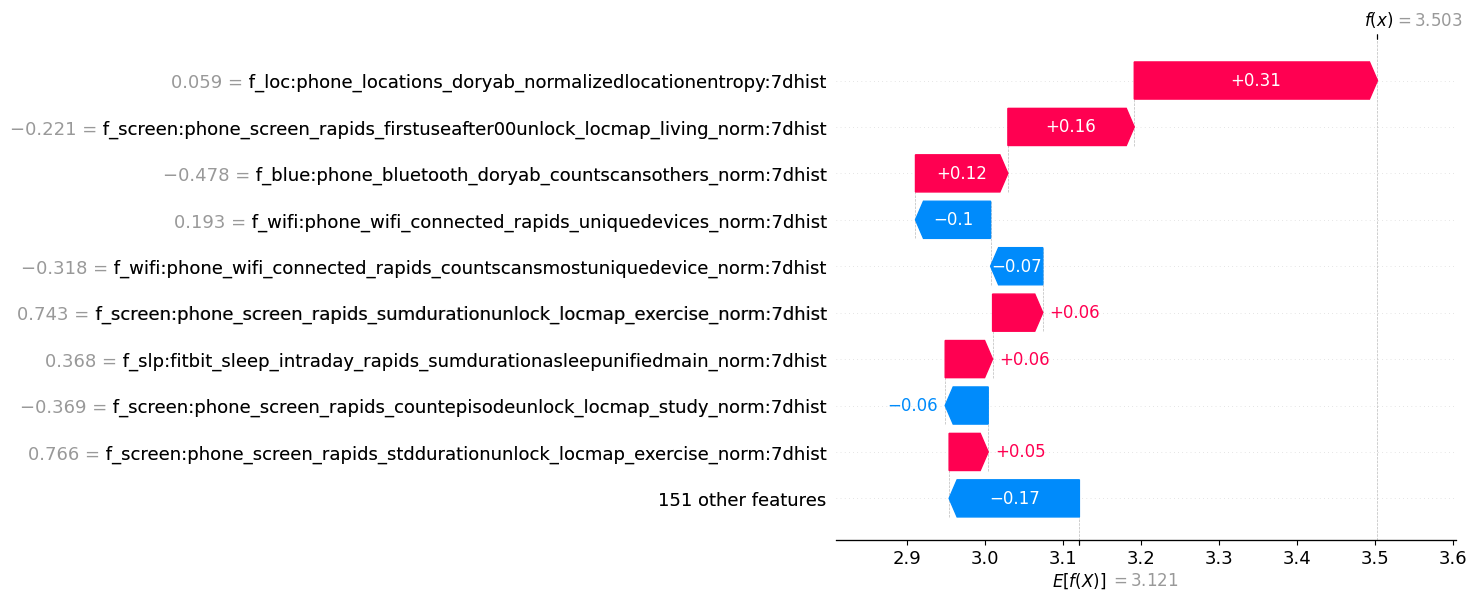

neg_panas_with_bfi
Cross_val scores: [-11.45073578 -11.28223671 -11.16697221 -11.75274485 -11.37378619]


100%|===================| 10577/10618 [03:27<00:00]        

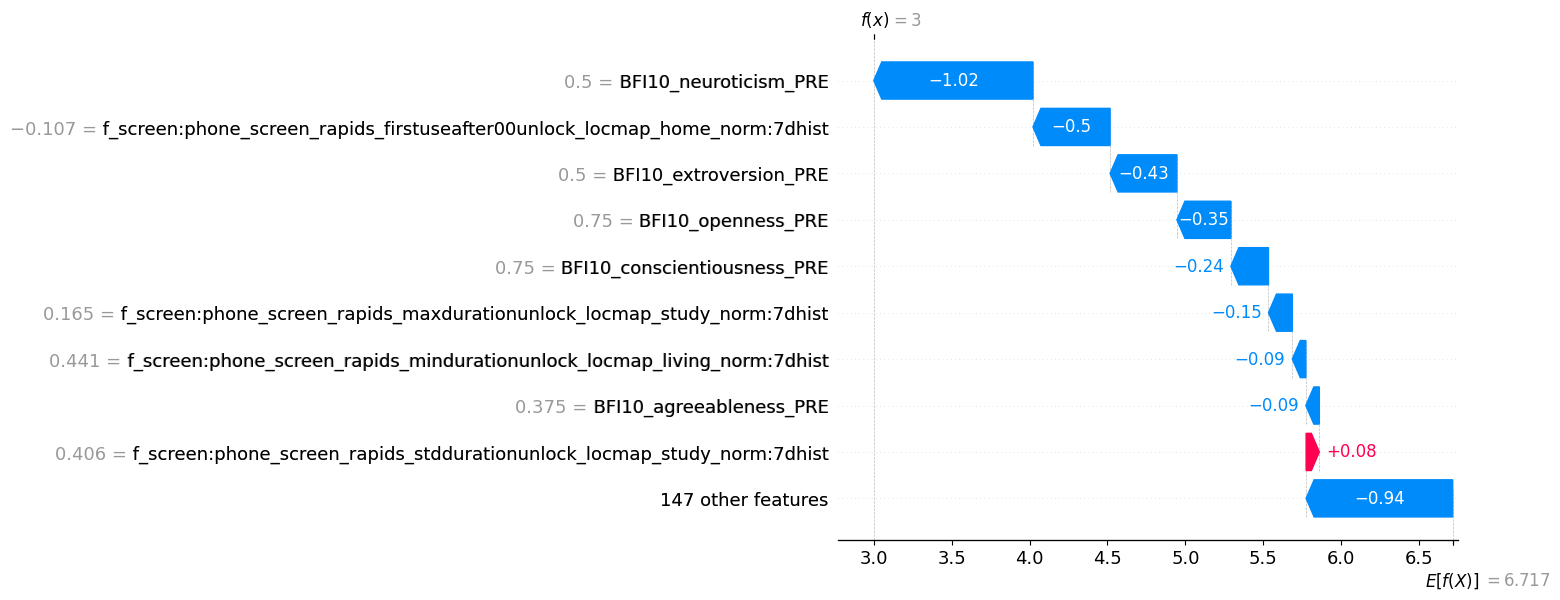

neg_panas_no_bfi
Cross_val scores: [-16.85101297 -16.47324396 -16.26700031 -16.74648845 -16.39144675]


100%|===================| 10580/10618 [03:32<00:00]        

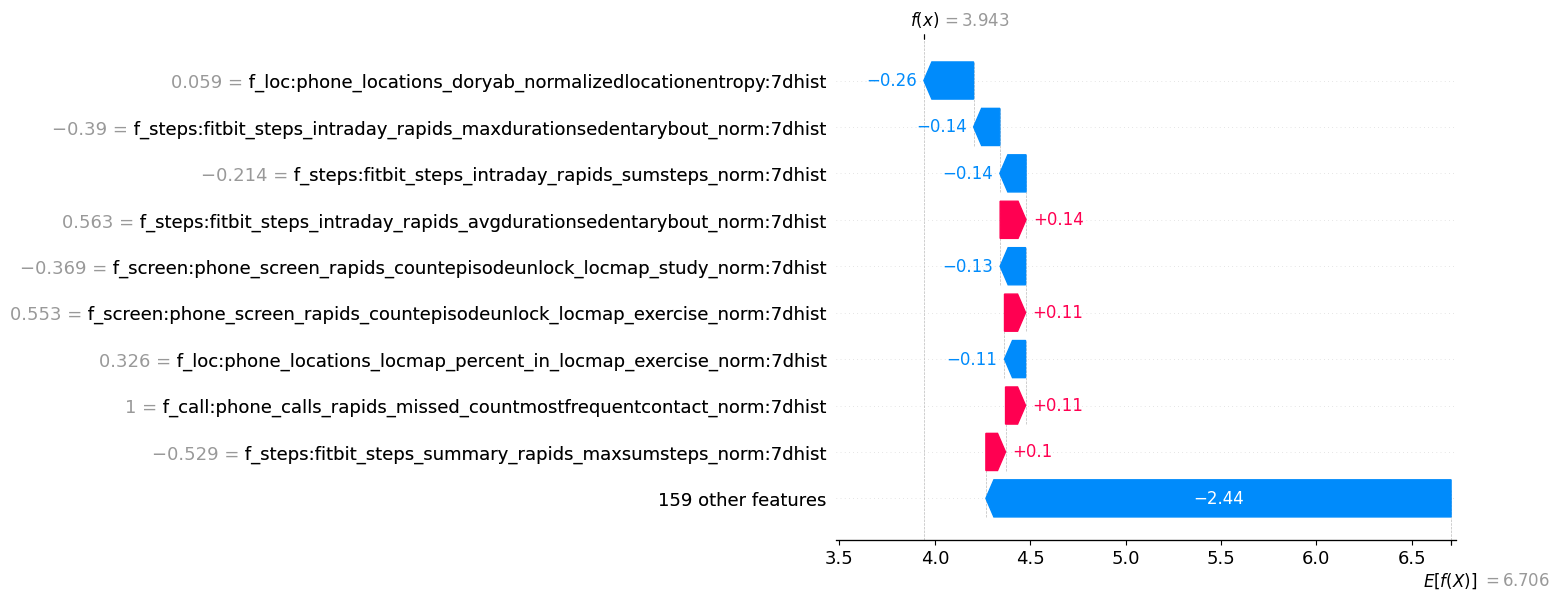

In [8]:
for key in datasets:
    print(key)
    params = best_params[key]
    dataset = datasets[key][0]
    target = datasets[key][1]
    
    rf = RandomForestRegressor(**params)
    rf.fit(dataset, target)
    cv_scores = cross_val_score(
        rf, 
        dataset, 
        target, 
        cv=kf, 
        scoring=mse_scorer
    )
    print(f'Cross_val scores: {cv_scores}')
    explainer = shap.TreeExplainer(rf, data=dataset, feature_names=dataset.columns)
    shap_values = explainer(dataset, check_additivity=False)
    shap.plots.waterfall(shap_values[0])